In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import rfcutils

2023-08-28 13:38:02.746913: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 13:38:03.287017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 177 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [3]:
testset_identifier = 'SampleEvalSetA'
soi_type, interference_sig_type = 'OFDMQPSK', 'CommSignal2'
all_sig_mixture = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}.npy'))
meta_data = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}_metadata.npy'))
# For SampleEvalSet
all_sig_mixture_groundtruth, all_sig1, all_bits1 = pickle.load(open(os.path.join('dataset', f'GroundTruth_{testset_identifier}_Dataset_{soi_type}_{interference_sig_type}.pkl'), 'rb'))

In [4]:
example_idx = 0

/home/gridsan/glcf411/.conda/envs/rfsionna/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


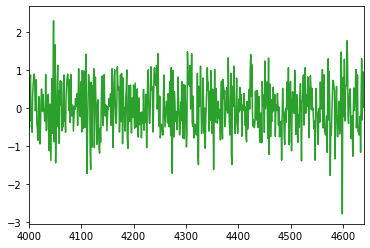

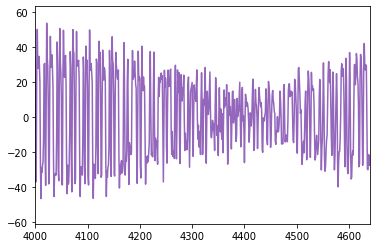

In [5]:
plt.figure()
plt.plot(all_sig1[example_idx], color='tab:green')
plt.xlim([4000, 4640])
plt.show()

plt.figure()
plt.plot(all_sig_mixture[example_idx], color='tab:purple')
plt.xlim([4000, 4640])
plt.show()

In [6]:
sig_len = 40960
def get_soi_generation_fn(soi_sig_type):
    if soi_sig_type == 'QPSK':
        generate_soi = lambda n, s_len: rfcutils.generate_qpsk_signal(n, s_len//16)
        demod_soi = rfcutils.qpsk_matched_filter_demod
    elif soi_sig_type == 'QAM16':
        generate_soi = lambda n, s_len: rfcutils.generate_qam16_signal(n, s_len//16)
        demod_soi = rfcutils.qam16_matched_filter_demod
    elif soi_sig_type ==  'QPSK2':
        generate_soi = lambda n, s_len: rfcutils.generate_qpsk2_signal(n, s_len//4)
        demod_soi = rfcutils.qpsk2_matched_filter_demod
    elif soi_sig_type == 'OFDMQPSK':
        generate_soi = lambda n, s_len: rfcutils.generate_ofdm_signal(n, s_len//80)
        _,_,_,RES_GRID = rfcutils.generate_ofdm_signal(1, sig_len//80)
        demod_soi = lambda s: rfcutils.ofdm_demod(s, RES_GRID)
    else:
        raise Exception("SOI Type not recognized")
    return generate_soi, demod_soi

generate_soi, demod_soi = get_soi_generation_fn(soi_type)

In [7]:
bits_demod, syms_demod = demod_soi(all_sig1[example_idx:example_idx+1]) # retain the shape, axis=0 should be the mixture index
np.allclose(bits_demod, all_bits1[example_idx:example_idx+1])

True